In [1]:
import pandas                       as pd
import numpy                        as np

import os
from datetime import datetime

from sklearn.model_selection        import train_test_split
from sklearn.metrics                import accuracy_score, classification_report, confusion_matrix
import scikitplot.metrics            as skplot

import tensorflow                   as tf
import tensorflow_hub               as hub

import bert
from bert                           import run_classifier
from bert                           import optimization
from bert                           import tokenization
from pathlib                        import Path
from HindiTokenizer                 import Tokenizer

In [2]:
df = pd.read_csv('../Data/cleaned hindi.csv')

In [3]:
df

,ID,Text,Sub-task A,Sub-task B,normalized lexicon,monolingual
0,C4.131,Bollywood film dekhne ke samay logic ghar mein...,NAG,NGEN,बॉलीवुड फ़िल्म देखने के समय तर्क घर में चोर मा...,बॉलीवुड फ़िल्म देखने समय तर्क में चोर मां झुंड...
1,C4.638,Chutiya movie...,NAG,NGEN,चुटिया चलचित्र...,चुटिया चलचित्र
2,C38.598,Us jaat bnde ka khene ka matlab tha mar daluga...,OAG,NGEN,हमें जाट बंदे का कहने का मतलब था समुद्र डालूगा...,हमें जाट बंदे कहने मतलब समुद्र डालूगा उपयोग पर...
3,C4.2101.1,@Feminism Is CANCER *un feminist yeh sahi hai ...,OAG,NGEN,@feminism है कैंसर *ए नारीवादी ये सही है परंतु...,feminism कैंसर नारीवादी सही परंतु मतलब थोड़ी सा...
4,C29.14.2,Amrit Anand अब तो जुड़े ही है उनको बोलो जुड़ने,NAG,NGEN,अमृत आनंद अब तो जुड़े ही है उनको बोलो जुड़ने,अमृत आनंद जुड़े बोलो जुड़ने
...,...,...,...,...,...,...
4976,C29.18,Are bhai konsi duniya mai rehate ho😂😂,NAG,NGEN,कर रहे हैं भाई कोनसी दुनिया मई रहते ho😂😂,भाई कोनसी दुनिया रहते
4977,C9.225,Sahi to bola,NAG,NGEN,सही सेवा वह थी,सही सेवा
4978,C7.1685,Or tum Kay Kar raya ho?,NAG,NGEN,या तुम kay कर राया हो?,तुम kay राया
4979,C36.692.1,Ye bhaat sahi hain par zyada dhin thine ga nah...,NAG,NGEN,हाँ चावल sahi हैं पर ज़्यादा मरना तेरा परंतु नह...,हाँ चावल sahi ज़्यादा मरना तेरा परंतु कहाँ खुदा...


In [56]:
df['monolingual'] = df['monolingual'].apply(lambda w : str(w).encode('utf-8'))

In [57]:
df = df.dropna()

In [4]:
label_encoder = {'NAG' : 0, 'OAG' : 1, 'CAG' : 2}
df = df.replace({'Sub-task A' : label_encoder})

In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=42) # HANDLE TEST TRAIN SPLIT

In [6]:
DATA_COLUMN = 'Text'
LABEL_COLUMN = 'Sub-task A'
label_list = df['Sub-task A'].unique() # Use the InputExample class from BERT's run_classifier code to create examples from the data
print(label_list)

[0 1 2]


In [7]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [25]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [14]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("monsoon-nlp/hindi-bert")

model = AutoModel.from_pretrained("monsoon-nlp/hindi-bert")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [15]:
# set sequences, 
# look here for more info - https://github.com/google-research/bert/blob/master/README.md#out-of-memory-issues
MAX_SEQ_LENGTH = 64
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)


INFO:tensorflow:Writing example 0 of 3984
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: None
INFO:tensorflow:tokens: [CLS] ये लोग संजू जैसी मूवी की खूब तारीफ करते हैं लेकिन कबीर सिंह जो कि पूरी तरह काल्पनिक कहानी पर आधारित उससे [UNK] रहे हैं । [SEP]
INFO:tensorflow:input_ids: 3 2349 2189 36654 4188 13366 1898 5885 30571 2156 1917 2294 9584 2571 1975 1952 3184 2370 6764 3605 1912 3147 4143 0 2324 1917 507 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:label: 0 (id = 0)
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: None
INFO:tensorflow:tokens: [CLS] ka ##b ##ir pre ##et ##i k ##o k ##uch ##h or ka ##r ##ne hi n ##i det ##

In [16]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels, num_labels):
    """Creates a classification model."""

    bert_module = hub.Module(
        BERT_MODEL_HUB,
        trainable=True)
    bert_inputs = dict(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids)
    bert_outputs = bert_module(
        inputs=bert_inputs,
        signature="tokens",
        as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

    # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable(
        "output_weights", [num_labels, hidden_size],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(
            tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)

In [17]:
# model_fn_builder creates our model function
# using the passed parameters for num_labels, learning_rate, etc.


def model_fn_builder(num_labels, learning_rate, num_train_steps, num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""
    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        """The `model_fn` for TPUEstimator."""

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:

            (loss, predicted_labels, log_probs) = create_model(is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            train_op = bert.optimization.create_optimizer(loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

            # Calculate evaluation metrics.
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                true_pos = tf.metrics.true_positives(label_ids, predicted_labels)
                true_neg = tf.metrics.true_negatives(label_ids, predicted_labels)
                false_pos = tf.metrics.false_positives(label_ids, predicted_labels)
                false_neg = tf.metrics.false_negatives(label_ids, predicted_labels)
                return {
                    "eval_accuracy": accuracy,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg
                }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode,
                                                  loss=loss,
                                                  train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode,
                                                  loss=loss,
                                                  eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            predictions = {
                'probabilities': log_probs,
                'labels': predicted_labels
            }
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn

In [18]:
# Compute train and warmup steps from batch size
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 50.0
# Warmup is a period of time where the learning rate 
# is small and gradually increase; usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [19]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [20]:
OUTPUT_DIR = '../Cache/Models/BERT-Hindi/'

In [21]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [22]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '../Cache/Models/BERT-Hindi/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6840beb0d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [23]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [27]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ../Cache/Models/BERT-Hindi/model.ckpt-0


INFO:tensorflow:Restoring parameters from ../Cache/Models/BERT-Hindi/model.ckpt-0


Instructions for updating:
Use standard file utilities to get mtimes.


Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into ../Cache/Models/BERT-Hindi/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into ../Cache/Models/BERT-Hindi/model.ckpt.


InvalidArgumentError: indices[62,2,0] = 34115 is not in [0, 30522)
	 [[node module_apply_tokens/bert/embeddings/embedding_lookup (defined at /opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]

Original stack trace for 'module_apply_tokens/bert/embeddings/embedding_lookup':
  File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 597, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/opt/conda/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/opt/conda/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-1eb71a2fa1b7>", line 3, in <module>
    estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 370, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1161, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1191, in _train_model_default
    features, labels, ModeKeys.TRAIN, self.config)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1149, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "<ipython-input-17-db1817b12c66>", line 20, in model_fn
    (loss, predicted_labels, log_probs) = create_model(is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
  File "<ipython-input-16-40a118e33f7a>", line 14, in create_model
    as_dict=True)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_hub/module.py", line 266, in __call__
    name=name)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_hub/native_module.py", line 610, in create_apply_graph
    import_scope=relative_scope_name)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 1453, in import_meta_graph
    **kwargs)[0]
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 1477, in _import_meta_graph_with_return_elements
    **kwargs))
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/meta_graph.py", line 809, in import_scoped_meta_graph_with_return_elements
    return_elements=return_elements)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/importer.py", line 405, in import_graph_def
    producer_op_list=producer_op_list)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/importer.py", line 517, in _import_graph_def_internal
    _ProcessNewOps(graph)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/importer.py", line 243, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3561, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3561, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3451, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [20]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [21]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-10-28T19:55:49Z


INFO:tensorflow:Starting evaluation at 2020-10-28T19:55:49Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ../Cache/Models/BERT/model.ckpt-3330


INFO:tensorflow:Restoring parameters from ../Cache/Models/BERT/model.ckpt-3330


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-10-28-19:57:00


INFO:tensorflow:Finished evaluation at 2020-10-28-19:57:00


INFO:tensorflow:Saving dict for global step 3330: eval_accuracy = 0.91369605, false_negatives = 47.0, false_positives = 34.0, global_step = 3330, loss = 0.4298469, true_negatives = 806.0, true_positives = 179.0


INFO:tensorflow:Saving dict for global step 3330: eval_accuracy = 0.91369605, false_negatives = 47.0, false_positives = 34.0, global_step = 3330, loss = 0.4298469, true_negatives = 806.0, true_positives = 179.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3330: ../Cache/Models/BERT/model.ckpt-3330


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3330: ../Cache/Models/BERT/model.ckpt-3330


{'eval_accuracy': 0.91369605,
 'false_negatives': 47.0,
 'false_positives': 34.0,
 'loss': 0.4298469,
 'true_negatives': 806.0,
 'true_positives': 179.0,
 'global_step': 3330}

In [22]:
def getPrediction(in_sentences):
    labels = ['NAG', 'OAG', 'CAG']
    input_examples = [run_classifier.InputExample(
        guid="", text_a=x, text_b=None, label=0) for x in in_sentences]  # here, "" is just a dummy label
    input_features = run_classifier.convert_examples_to_features(
        input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
    predict_input_fn = run_classifier.input_fn_builder(
        features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
    predictions = estimator.predict(predict_input_fn)
    return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [23]:
pred_sentences = list(test['Text'])

In [24]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 1066


INFO:tensorflow:Writing example 0 of 1066


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] best reply to feminist ##s & liberals . . . . . ! ! [ # ka ##bir ##sing ##h ] ( http : / / www . youtube . com / results ? search _ query = % 23 ##ka ##bir ##sing ##h ) is a best movie . . . . [SEP]


INFO:tensorflow:tokens: [CLS] best reply to feminist ##s & liberals . . . . . ! ! [ # ka ##bir ##sing ##h ] ( http : / / www . youtube . com / results ? search _ query = % 23 ##ka ##bir ##sing ##h ) is a best movie . . . . [SEP]


INFO:tensorflow:input_ids: 101 2190 7514 2000 10469 2015 1004 13350 1012 1012 1012 1012 1012 999 999 1031 1001 10556 17706 7741 2232 1033 1006 8299 1024 1013 1013 7479 1012 7858 1012 4012 1013 3463 1029 3945 1035 23032 1027 1003 2603 2912 17706 7741 2232 1007 2003 1037 2190 3185 1012 1012 1012 1012 102 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2190 7514 2000 10469 2015 1004 13350 1012 1012 1012 1012 1012 999 999 1031 1001 10556 17706 7741 2232 1033 1006 8299 1024 1013 1013 7479 1012 7858 1012 4012 1013 3463 1029 3945 1035 23032 1027 1003 2603 2912 17706 7741 2232 1007 2003 1037 2190 3185 1012 1012 1012 1012 102 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] nice , , , , , [SEP]


INFO:tensorflow:tokens: [CLS] nice , , , , , [SEP]


INFO:tensorflow:input_ids: 101 3835 1010 1010 1010 1010 1010 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3835 1010 1010 1010 1010 1010 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] agree ##e [SEP]


INFO:tensorflow:tokens: [CLS] agree ##e [SEP]


INFO:tensorflow:input_ids: 101 5993 2063 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5993 2063 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] nice good job [SEP]


INFO:tensorflow:tokens: [CLS] nice good job [SEP]


INFO:tensorflow:input_ids: 101 3835 2204 3105 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3835 2204 3105 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] @ pr ##ati ##k bo ##rade sorry brother so write such comment because something similar happened in my life also in past but is ending is very different in real life . [SEP]


INFO:tensorflow:tokens: [CLS] @ pr ##ati ##k bo ##rade sorry brother so write such comment because something similar happened in my life also in past but is ending is very different in real life . [SEP]


INFO:tensorflow:input_ids: 101 1030 10975 10450 2243 8945 13662 3374 2567 2061 4339 2107 7615 2138 2242 2714 3047 1999 2026 2166 2036 1999 2627 2021 2003 4566 2003 2200 2367 1999 2613 2166 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1030 10975 10450 2243 8945 13662 3374 2567 2061 4339 2107 7615 2138 2242 2714 3047 1999 2026 2166 2036 1999 2627 2021 2003 4566 2003 2200 2367 1999 2613 2166 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ../Cache/Models/BERT/model.ckpt-3330


INFO:tensorflow:Restoring parameters from ../Cache/Models/BERT/model.ckpt-3330


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [25]:
x = np.array(predictions)
np.shape(x)

(1066, 3)

In [26]:
texts = []
predicted_sentiment = []
for i in range(len(predictions)):
    texts.append(predictions[i][0])
    predicted_sentiment.append(predictions[i][2])

In [27]:
output_dict = {'Text' : texts, 'predicted_label' : predicted_sentiment}
output_df = pd.DataFrame(output_dict)
output_df = output_df.replace({'predicted_label' : label_encoder})

In [28]:
if not os.path.exists('output'):
    os.makedirs('output')

In [29]:
output_df.to_excel('output/output_bert.xlsx', index = False)

## Accuracy

In [31]:
score = accuracy_score(output_df['predicted_label'], test[LABEL_COLUMN])
print("The test accuracy is : {} %".format(score * 100))

The test accuracy is : 76.31887456037515 %


              precision    recall  f1-score   support

           0       0.95      0.96      0.95       840
           1       0.05      0.06      0.06       105
           2       0.05      0.04      0.04       121

    accuracy                           0.77      1066
   macro avg       0.35      0.35      0.35      1066
weighted avg       0.76      0.77      0.76      1066



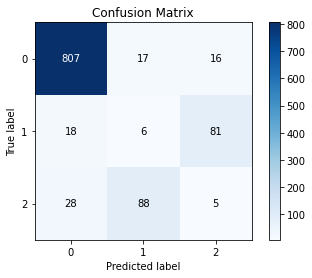

In [39]:
skplot.plot_confusion_matrix(test[LABEL_COLUMN], output_df['predicted_label'])
print(classification_report(test[LABEL_COLUMN], output_df['predicted_label']))